# I] Import functions and options

In [1]:
import pandas, numpy, seaborn
import scipy, scipy.stats
import matplotlib, matplotlib.pyplot as plt
# this is a trick to make figures look nicer
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':20, 'ytick.labelsize':10, 'figure.figsize':(12, 8)})
from matplotlib_venn import venn2

In [2]:
input_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7//0 in_silico/Python/1)data_input/'

In [3]:
output_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/3)output/'

# II] Data download

In [4]:
%%time
# DL data ATG7 isoform expression
path = output_file_directory + "/ATG7/TCGA_GTEX/dataframes_for_input/df_ATG7_NormPrim.csv"
df_ATG7_NormPrim= pandas.read_csv(path, sep = ",")

#remove Survival information
df_ATG7_NormPrim.drop(df_ATG7_NormPrim.columns[[3, 4]], axis = 1, inplace = True)

print(df_ATG7_NormPrim.shape)
df_ATG7_NormPrim.head(2)

(16614, 20)
Wall time: 87.3 ms


,sample,Sample_Type,Primary_Site,ATG7,ATG7_1,ATG7_2,ATG7_3,ATG7_total,ATG7_1tpm,ATG7_2tpm,ATG7_3tpm,log2_p1_ATG7_total,log2_p1_ATG7_1,log2_p1_ATG7_2,ATG7_prot_tot,ATG7_1perc,ATG7_2perc,ATG7_3perc,ATG7_1norm,ATG7_2norm
0,GTEX-ZTTD-0326-SM-57WFW,Normal Tissue,Muscle,5.042,3.860,2.390,0.2642,32.944283,14.519306,5.240574,1.199970,5.085097,3.955992,2.641679,20.95985,69.271996,25.002916,5.725088,0.440723,0.159074
1,GTEX-PX3G-1626-SM-2S1PT,Normal Tissue,Muscle,4.252,2.322,1.956,1.1320,19.052710,4.999249,3.878848,2.190624,4.325725,2.584782,2.286540,11.06872,45.165557,35.043325,19.791118,0.262390,0.203585


In [8]:
#split to have Normal (GTEX) and Primary (TCGA)
df_ATG7_Normal_orig = df_ATG7_NormPrim[df_ATG7_NormPrim['sample'].str.startswith('GTEX')]
print('Normal tissue smaples:', len(df_ATG7_Normal_orig))
df_ATG7_Primary_orig = df_ATG7_NormPrim[df_ATG7_NormPrim['sample'].str.startswith('TCGA')]
print('Primary tumors smaples:', len(df_ATG7_Primary_orig))

Normal tissue smaples: 7429
Primary tumors smaples: 9185


# III] ATG7 expression

## A) ATG7 expression

In [9]:
#How many samples represent each organs?
all_data = [[df_ATG7_Normal_orig, 'normal_tissue'], [df_ATG7_Primary_orig, 'primary_tumor']]

for data in all_data: 
    print(data[1].upper())
    print(data[0]["Primary_Site"].value_counts())
    print('___________________________________')

NORMAL_TISSUE
Brain              1152
Esophagus           653
Blood Vessel        606
Skin                556
Adipose Tissue      515
Muscle              396
Heart               377
Blood               337
Colon               308
Lung                288
Thyroid             279
Nerve               278
Breast              179
Stomach             174
Pancreas            167
Testis              165
Adrenal Gland       128
Liver               110
Pituitary           107
Prostate            100
Spleen              100
Small Intestine      92
Ovary                88
Vagina               85
Uterus               78
Salivary Gland       55
Kidney               28
Cervix Uteri         10
Bladder               9
Fallopian Tube        5
Name: Primary_Site, dtype: int64
___________________________________
PRIMARY_TUMOR
Breast                     1092
Lung                       1011
Kidney                      884
Brain                       662
Head And Neck Region        518
Thyroid Gland          

In [10]:
#Remove tissues with lower than 20 samples. 
dfs = df_ATG7_Normal_orig, df_ATG7_Primary_orig
infos = 'Normal:', 'Primary:'
element_to_delete = []
df_ATG7_filtered_list = []

for i in range(len(dfs)):
    df = dfs[i]
    info = infos[i]
    print(info)
    
    #select all the elements in primary sites, and note which one are <20
    working_elements = df["Primary_Site"].to_list()
    for element in working_elements:
        if working_elements.count(element) < 20:
            element_to_delete.append(element)
            
    #Convert to Set() to have a clear list because it cannot contoin duplicate. 
    element_to_delete = set(element_to_delete)
    print('elements with less than 20 samples are:', element_to_delete)
    
    #Remove the samples where the tissue is represented less than 20 times
    print('shape with all the elements', df.shape)
    for element in element_to_delete:
        df = df.loc[df["Primary_Site"] != element]
    print('shape after removing the elements', df.shape)
    
    df_ATG7_filtered_list.append(df)
    print()
    
df_ATG7_Normal = df_ATG7_filtered_list[0]
df_ATG7_Primary = df_ATG7_filtered_list[1]

Normal:
elements with less than 20 samples are: {'Bladder', nan, 'Fallopian Tube', 'Cervix Uteri'}
shape with all the elements (7429, 20)
shape after removing the elements (7405, 20)

Primary:
elements with less than 20 samples are: {'Bladder', nan, 'Fallopian Tube', 'Cervix Uteri'}
shape with all the elements (9185, 20)
shape after removing the elements (8778, 20)



In [11]:
#use same name, sometimes same tissue but different names
#Calculate FoldChange + pvalue for each tissue (normal vs primary) for both isoform
#plot it

In [13]:
#Change names to regroup Thyroid and Thyroid Gland
df_ATG7_Primary['Primary_Site'].replace('Thyroid Gland', 'Thyroid', inplace=True)
#to see what tissues are present in both group
norm_sites = df_ATG7_Normal['Primary_Site']
prim_sites = df_ATG7_Primary['Primary_Site']

set1 = set(norm_sites)
set2 = set(prim_sites)
inter_site = set1.intersection(set2)
inter_site

{'Adrenal Gland',
 'Brain',
 'Breast',
 'Colon',
 'Esophagus',
 'Kidney',
 'Liver',
 'Lung',
 'Ovary',
 'Pancreas',
 'Prostate',
 'Skin',
 'Stomach',
 'Testis',
 'Thyroid',
 'Uterus'}

In [14]:
#see if I can rename some to mix the two group
group1 = set1.symmetric_difference(set2) & set1
print(group1)

group2 = set1.symmetric_difference(set2) & set2
print(group2)

{nan, 'Muscle', 'Vagina', 'Blood', 'Heart', 'Nerve', 'Adipose Tissue', 'Spleen', 'Small Intestine', 'Blood Vessel', 'Pituitary', 'Salivary Gland'}
{'Lining Of Body Cavities', 'Cervix', 'Bile Duct', 'Endometrium', 'Soft Tissue,Bone', 'Thymus', 'Rectum', 'Lymphatic Tissue', 'Eye', 'Paraganglia', 'Head And Neck Region'}


In [15]:
dfs = df_ATG7_Normal, df_ATG7_Primary
dfs_inter_L = []
for df in dfs:
    df_inter = df[df['Primary_Site'].isin(inter_site)]
    dfs_inter_L.append(df_inter)
    
df_ATG7_Normal=dfs_inter_L[0]
df_ATG7_Primary=dfs_inter_L[1]
print(df_ATG7_Primary["Primary_Site"].value_counts())

Breast           1092
Lung             1011
Kidney            884
Brain             662
Thyroid           504
Prostate          495
Ovary             419
Stomach           414
Liver             369
Colon             288
Esophagus         181
Pancreas          178
Testis            148
Skin              102
Adrenal Gland      77
Uterus             57
Name: Primary_Site, dtype: int64


In [16]:
all_data = [[df_ATG7_Normal, 'normal_tissue'], [df_ATG7_Primary, 'primary_tumor']]
df_sampletype_l  = []

for data in all_data:
    print(data[1].upper())
    
    ##select columns
    df_sampletype = data[0][['Primary_Site',
                             'ATG7_total',
                             'ATG7_1tpm',
                             'ATG7_2tpm',
                             'ATG7_1perc',
                             'ATG7_2perc',
                             'ATG7_3perc']]
     
    ##Column rename
    df_sampletype = df_sampletype.rename(columns = {'Primary_Site' : 'Primary Site', 
                                                    'ATG7_total': 'tpm ATG7',
                                                    'ATG7_1tpm': 'tpm ATG7(1)',
                                                    'ATG7_2tpm': 'tpm ATG7(2)',
                                                    'ATG7_1perc' : "% ATG7(1)",
                                                    'ATG7_2perc' : "% ATG7(2)",
                                                    'ATG7_3perc' : "% ATG7(3)"})
       
    ##Groupby to have merge of all the primary site 
    df_sampletype= df_sampletype.groupby('Primary Site').agg(numpy.mean)
    df_sampletype = df_sampletype.round(2)
    
    ##save_df in a list
    df_sampletype_l.append(df_sampletype)
    print()
    print(df_sampletype.head())
    print('_______________________________________________________________________')    
    

df_sampletype_normal = df_sampletype_l[0]
df_sampletype_primary = df_sampletype_l[1]

NORMAL_TISSUE

               tpm ATG7  tpm ATG7(1)  tpm ATG7(2)  % ATG7(1)  % ATG7(2)  \
Primary Site                                                              
Adrenal Gland     11.60         6.15         1.54      78.83      17.67   
Brain              7.94         5.65         0.30      94.98       4.08   
Breast            12.68         7.06         1.22      83.06      14.29   
Colon              9.51         5.55         0.83      84.73      12.56   
Esophagus         10.73         5.53         1.46      77.79      18.25   

               % ATG7(3)  
Primary Site              
Adrenal Gland       3.50  
Brain               0.94  
Breast              2.65  
Colon               2.71  
Esophagus           3.96  
_______________________________________________________________________
PRIMARY_TUMOR

               tpm ATG7  tpm ATG7(1)  tpm ATG7(2)  % ATG7(1)  % ATG7(2)  \
Primary Site                                                              
Adrenal Gland     11.35         7

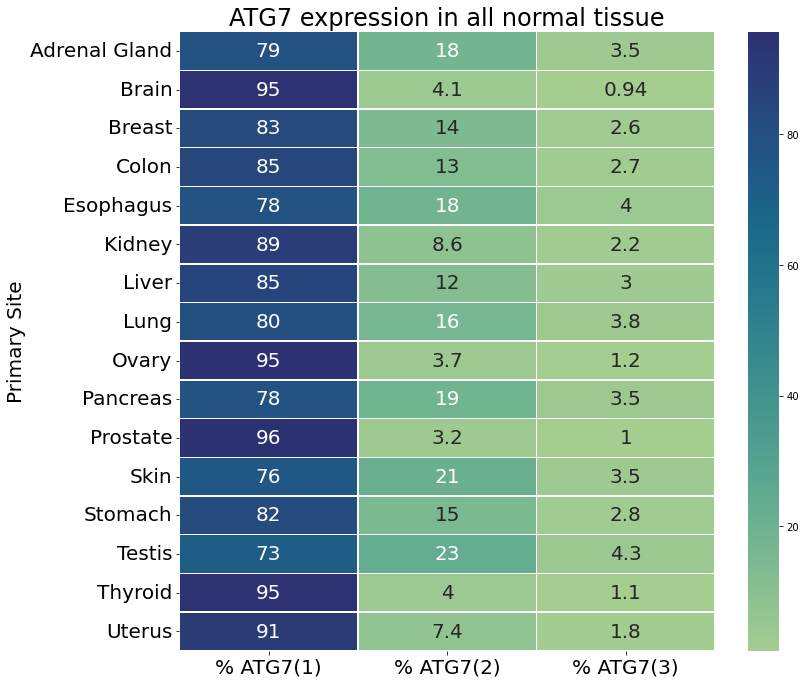

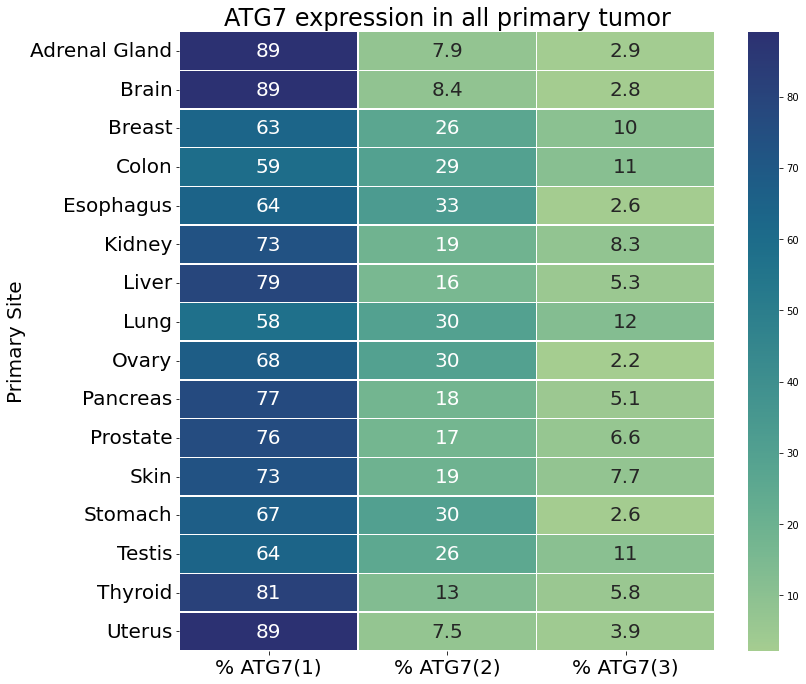

<Figure size 864x576 with 0 Axes>

In [75]:
all_data = [[df_sampletype_normal, 'normal tissue'], [df_sampletype_primary, 'primary tumor']]

for data in all_data:
    df = data[0]
    label = data[1]

    HeatMap_df = df[['% ATG7(1)', '% ATG7(2)', '% ATG7(3)']]
    heatmap = seaborn.heatmap(HeatMap_df, annot=True, cmap="crest", linewidths=.5)
    plt.title('ATG7 expression in all '+label)
    plt.yticks(fontsize=20)
    plt.subplots_adjust(top=1.2)
    
    path = 'ATG7/TCGA_GTEX/all_tissue/figs_ATG7_characterisation/only tissues in the both groups/'
    name = 'heatmap_organs_' + label
    plt.savefig(output_file_directory+path+name+'.svg')
    plt.show()
    plt.clf()

tpm ATG7
normal tissue
    Primary Site  tpm ATG7
0  Adrenal Gland     11.60
1          Brain      7.94
primary tumor
    Primary Site  tpm ATG7
0  Adrenal Gland     11.35
1          Brain     17.50


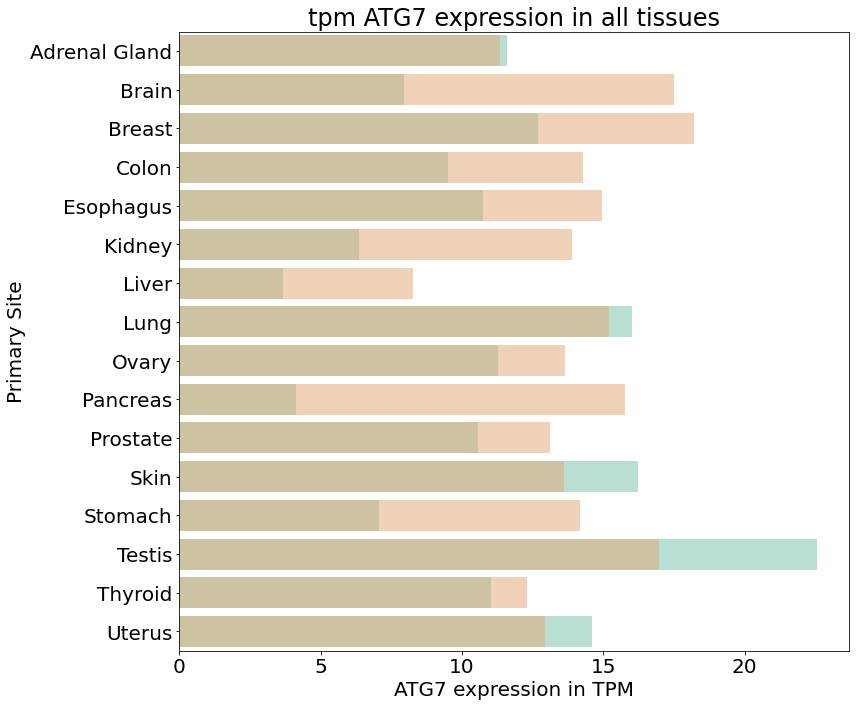

tpm ATG7(1)
normal tissue
    Primary Site  tpm ATG7(1)
0  Adrenal Gland         6.15
1          Brain         5.65
primary tumor
    Primary Site  tpm ATG7(1)
0  Adrenal Gland         7.80
1          Brain        11.21


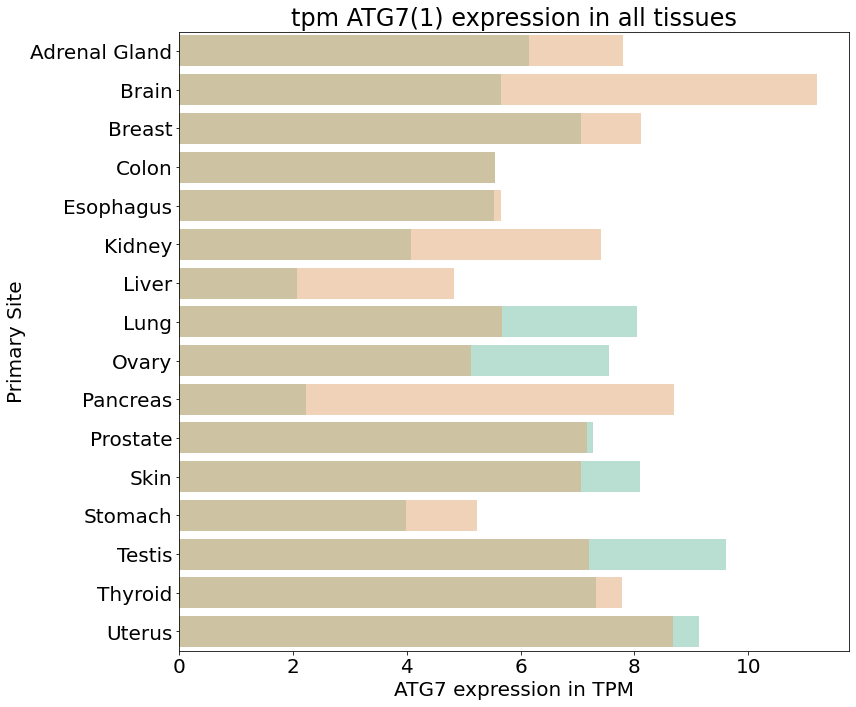

tpm ATG7(2)
normal tissue
    Primary Site  tpm ATG7(2)
0  Adrenal Gland         1.54
1          Brain         0.30
primary tumor
    Primary Site  tpm ATG7(2)
0  Adrenal Gland         0.83
1          Brain         1.21


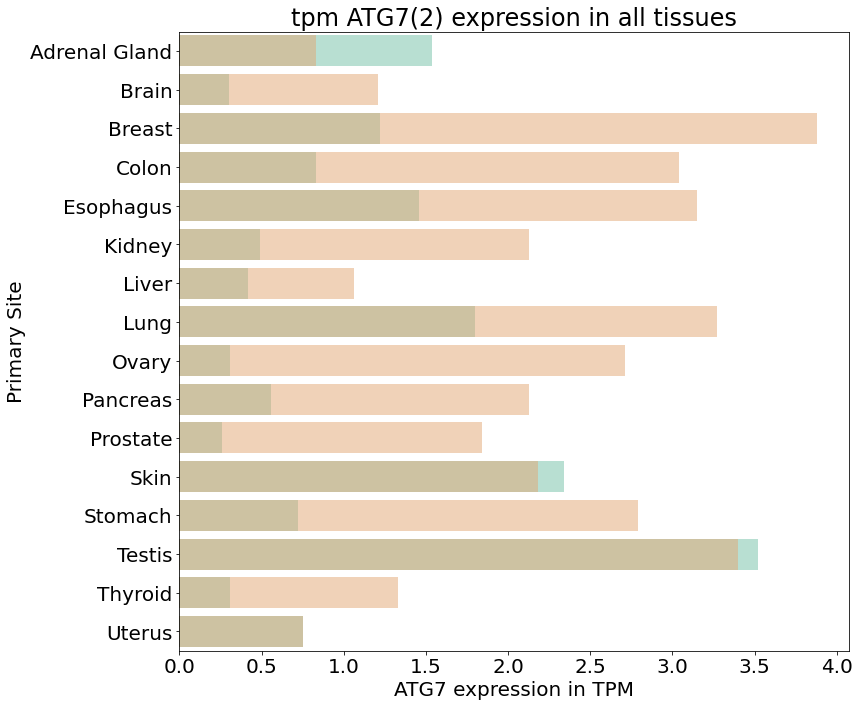

<Figure size 864x576 with 0 Axes>

In [90]:
dfs = df_sampletype_normal, df_sampletype_primary
colors = 'mediumaquamarine', 'sandybrown'

isoforms = 'tpm ATG7', 'tpm ATG7(1)', 'tpm ATG7(2)'

for isoform in isoforms:
    print(isoform)

    for i in range(len(dfs)):
        df = dfs[i]
        label = infos[i]
        color_ = colors[i]

        print(label)
        hist_df = df.reset_index()
        hist_df = hist_df[['Primary Site', isoform]]
        print(hist_df.head(2))

        # Seaborn
        seaborn.barplot(data = hist_df, x =  isoform, y = 'Primary Site', alpha=0.5, color = color_)
        plt.title(isoform+' expression in all tissues')
        plt.xlabel('ATG7 expression in TPM')
        plt.subplots_adjust(top=1.2)
        plt.yticks(fontsize=20)

        name = 'histo_organs_'
        #     plt.savefig(output_file_directory+path+name+'.svg')
        #     plt.show()
    plt.show()
    plt.clf()

normal tissue
    Primary Site  tpm ATG7
0  Adrenal Gland     11.60
1          Brain      7.94
2         Breast     12.68
min: 3.68
max: 22.56


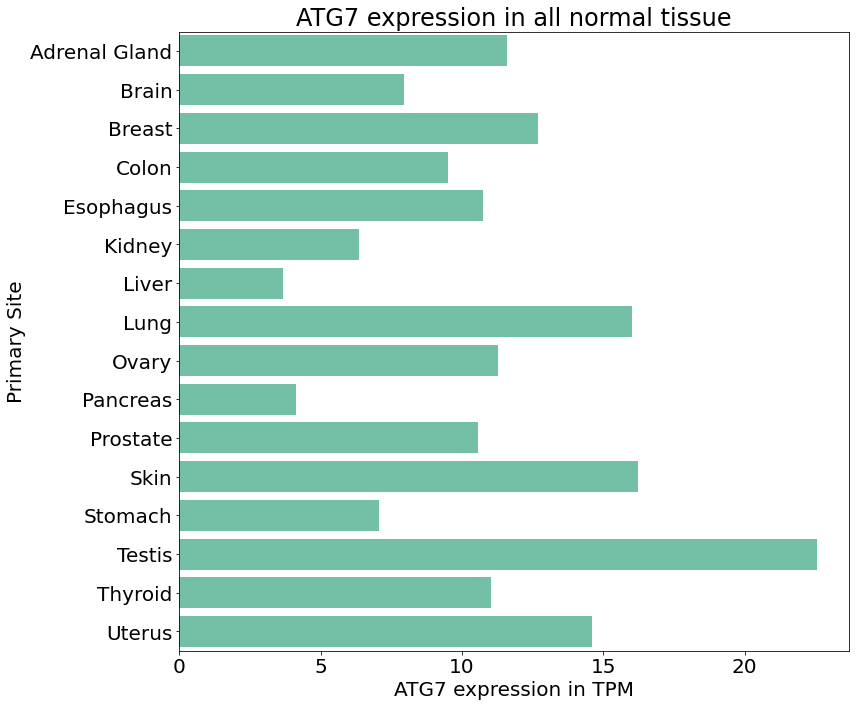

primary tumor
    Primary Site  tpm ATG7
0  Adrenal Gland     11.35
1          Brain     17.50
2         Breast     18.21
min: 8.27
max: 18.21


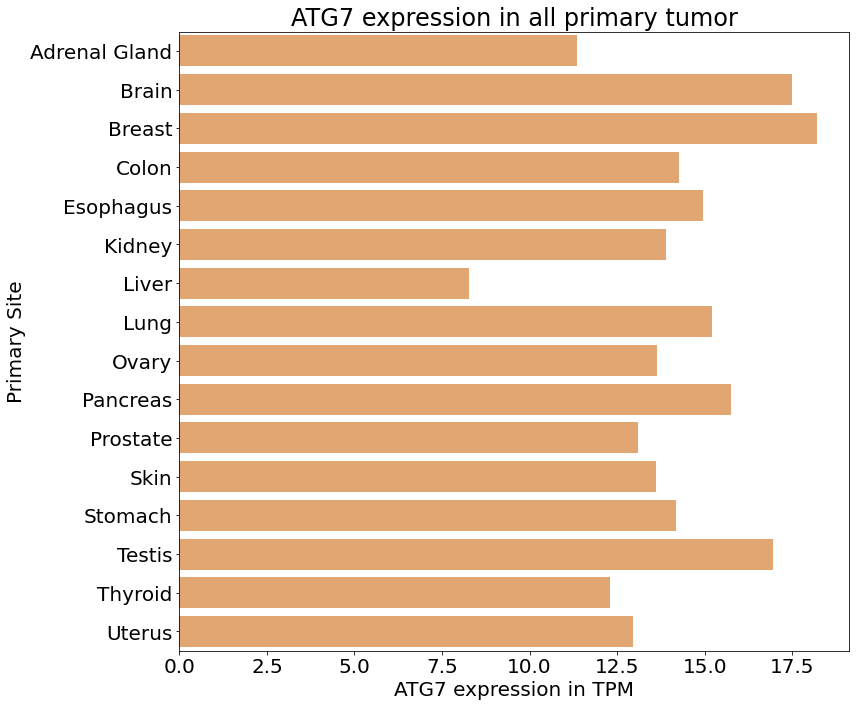

<Figure size 864x576 with 0 Axes>

In [19]:
all_data = [[df_sampletype_normal, 'normal tissue', 'mediumaquamarine'], 
            [df_sampletype_primary, 'primary tumor', 'sandybrown']]

for data in all_data:
    df = data[0]
    label = data[1]
    color_ = data[2]
    
    print(label)
    hist_df = df.reset_index()
    hist_df = hist_df[['Primary Site','tpm ATG7']]
    print(hist_df.head(3))
    print("min:", hist_df['tpm ATG7'].min())
    print("max:", hist_df['tpm ATG7'].max())
    
    # Seaborn
    seaborn.barplot(data = hist_df, x =  'tpm ATG7', y = 'Primary Site', color = color_)
    plt.title('ATG7 expression in all '+ label)
    plt.xlabel('ATG7 expression in TPM')
    plt.subplots_adjust(top=1.2)
    plt.yticks(fontsize=20)
    
    name = 'histo_organs_' + label
    plt.savefig(output_file_directory+path+name+'.svg')
    plt.show()
    plt.clf()

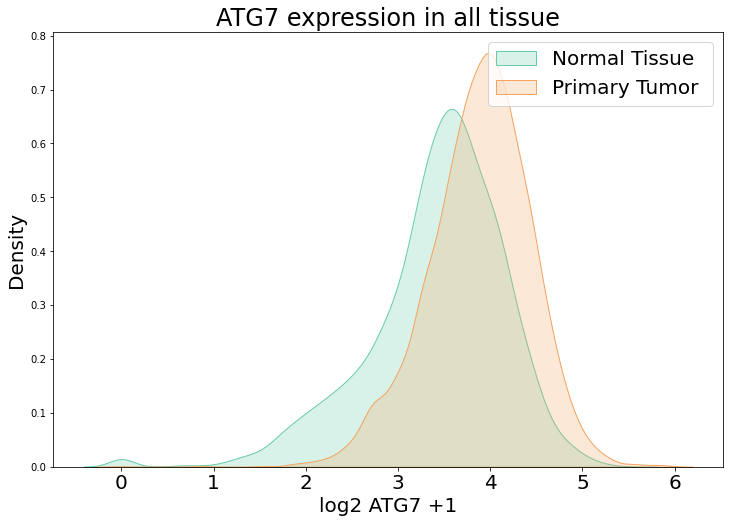

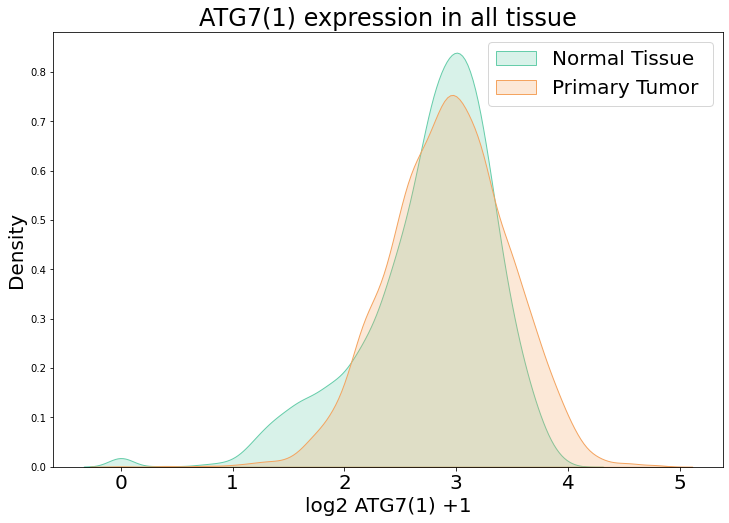

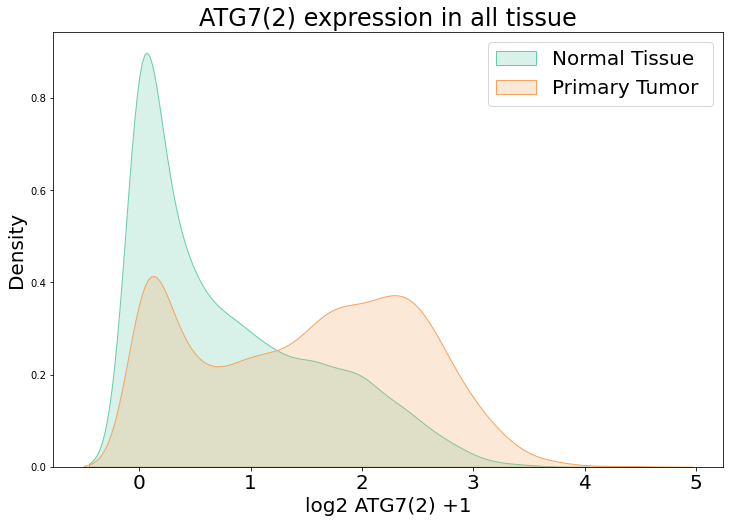

<Figure size 864x576 with 0 Axes>

In [20]:
# Distribution graph, for ATG7, iso1 & iso2
all_dfs = [[df_ATG7_Normal, 'in all tissue', df_ATG7_Primary, 'all primary tumors']]

isoforms = [['log2_p1_ATG7_total', 'ATG7'], ['log2_p1_ATG7_1', 'ATG7(1)'], ['log2_p1_ATG7_2', 'ATG7(2)']]


for df in all_dfs:
  for isoform in isoforms:
    xData = df[0][isoform[0]]
    x2Data = df[2][isoform[0]]

    seaborn.kdeplot(xData, color = 'mediumaquamarine', fill = True)
    seaborn.kdeplot(x2Data, color = 'sandybrown', fill = True)

    plt.xlabel('log2 '+ isoform[1]+ ' +1')
    plt.title(isoform[1]+ ' expression ' + df[1] )
    plt.legend(labels=["Normal Tissue","Primary Tumor "])
    title_file = 'distrib_' + isoform[1]
    plt.savefig(output_file_directory+path+title_file+'.svg')
    plt.show()
    plt.clf()

## A.bis) ATG7 isoforms expression per tissues

In [21]:
# expression per tissue and per isoform

In [ ]:
df_ATG7_Normal.head(2)

In [72]:
#Remove tissues with lower than 20 samples. 
p_value1_l = []
p_value2_l = []

foldchange_1_l = []
foldchange_2_l = []

tissues = set( list(df_ATG7_Normal["Primary_Site"]) )
isoforms = 'ATG7_1', 'ATG7_2'
pvalue_lists = p_value1_l, p_value2_l
fc_lists = foldchange_1_l, foldchange_2_l

tissue_l = []

for tissue in tissues:
    tissue_l.append(tissue)
    
    df1 = df_ATG7_Normal[df_ATG7_Normal['Primary_Site'] == tissue]
    df2 = df_ATG7_Primary[df_ATG7_Primary['Primary_Site'] == tissue]
    
    for i in range(len(isoforms)):
        isoform = isoforms[i]
        pvalue_l = pvalue_lists[i]
        foldchange_l = fc_lists[i]
        
        #add FoldChange (primary - normal)
        fc = df2[isoform].median() - df1[isoform].median()
        foldchange_l.append(fc)
        # Mann-Whitney analysis ATG7(1)
        statistic, pvalue = scipy.stats.mannwhitneyu(df1[isoform], df2[isoform])
        Pvalue = "{:.3E}".format(pvalue)
        pvalue_l.append(Pvalue)
        
#save in dict, then to df
d = dict(tissue = tissue_l, 
         FC_ATG7_1 = foldchange_1_l, p_value_iso1 = p_value1_l, 
         FC_ATG7_2 = foldchange_2_l, p_value_iso2 = p_value2_l)

df_ATG7_diff_tissues = pandas.DataFrame.from_dict(d, orient='index')

#Transpose to have a better table
df_ATG7_diff_tissues = df_ATG7_diff_tissues.transpose()

#alphabetic order and reset_index
df_ATG7_diff_tissues = df_ATG7_diff_tissues.sort_values('tissue')
df_ATG7_diff_tissues.set_index('tissue',inplace = True, drop = True)

df_ATG7_diff_tissues

,FC_ATG7_1,p_value_iso1,FC_ATG7_2,p_value_iso2
tissue,,,,
Adrenal Gland,0.319,9.323E-05,-2.48535,8.599E-06
Brain,1.0195,9.726E-205,2.5067,7.520E-65
Breast,0.169,1.205E-06,1.7457,1.295E-33
Colon,0.0295,4.222E-01,2.46825,1.040E-54
Esophagus,-0.031,4.601E-01,1.7891,1.153E-26
Kidney,0.78,2.695E-08,5.2548,2.451E-08
Liver,1.2688,1.889E-46,3.1339,6.641E-13
Lung,-0.557,1.596E-53,1.0092,3.658E-27
Ovary,-0.6355,1.363E-25,4.208,8.808E-27


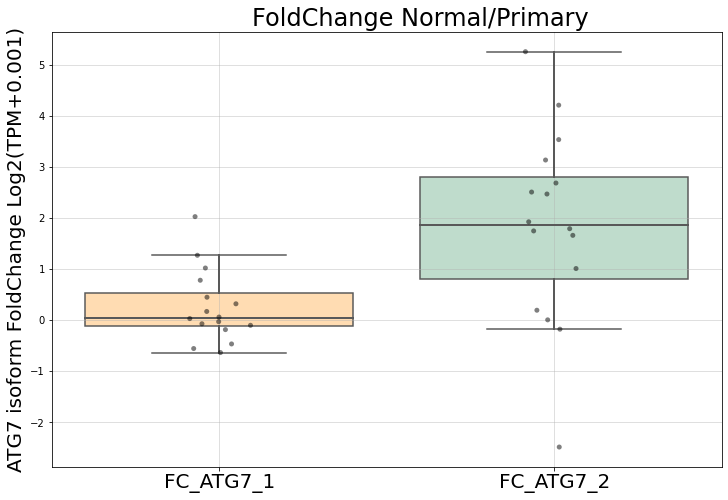

In [70]:
 #Graph, Bloxplot
df = df_ATG7_diff_tissues[['FC_ATG7_1','FC_ATG7_2']]

ax = seaborn.boxplot(palette = 'Set2', data = df, 
                     medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)
seaborn.stripplot(data = df, color = 'black', alpha = 0.5)

# Select which box you want to change    
box_ATG7_1 = ax.artists[0]
box_ATG7_1.set_facecolor('darkorange')
box_ATG7_2 = ax.artists[1]
box_ATG7_2.set_facecolor('seagreen')

# adding transparency to colors
for patch in ax.artists:
     r, g, b, a = patch.get_facecolor()
     patch.set_facecolor((r, g, b, .3))

plt.ylabel('ATG7 isoform FoldChange Log2(TPM+0.001)')
#     plt.ylim(0.45,1.5)
plt.xlabel('')
text_title = 'FoldChange Normal/Primary'
plt.title(text_title, x=.55)
plt.grid(alpha = 0.5)

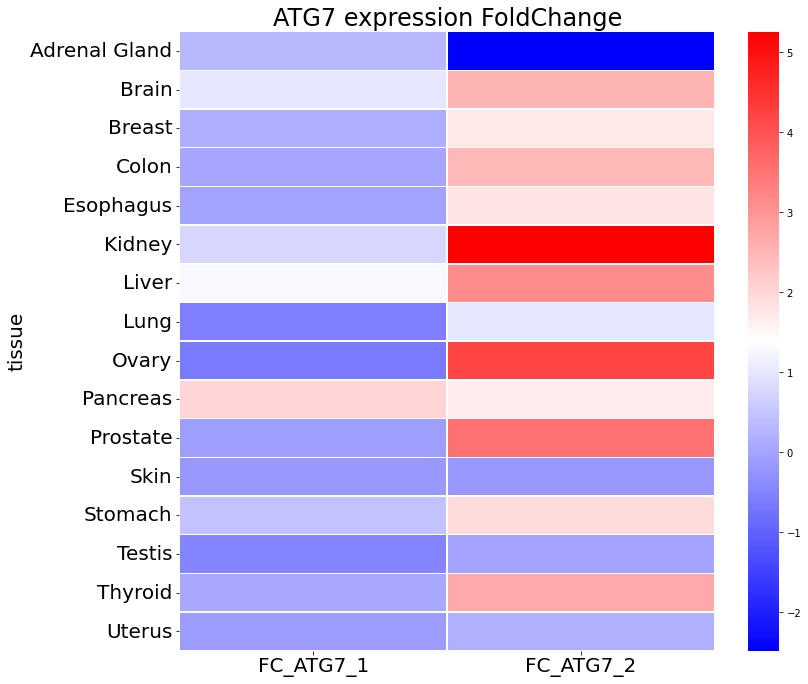

In [89]:
df = df_ATG7_diff_tissues

HeatMap_df = df[['FC_ATG7_1', 'FC_ATG7_2']]
HeatMap_df = HeatMap_df.astype(float)
seaborn.heatmap(HeatMap_df, annot=False, cmap="bwr", linewidths=.5)
plt.title('ATG7 expression FoldChange')
plt.yticks(fontsize=20)
plt.subplots_adjust(top=1.2)

## B) Percentage do not express ATG7 isoforms

In [91]:
#Percentage of patients: 
all_dfs = [[df_ATG7_Normal, 'all normal tissue'], [df_ATG7_Primary, 'all primary tumor']]

isoforms = [['ATG7_total', 'ATG7'], ['ATG7_1tpm', 'ATG7(1)'], 
            ['ATG7_2tpm', 'ATG7(2)'], ['ATG7_3tpm', 'ATG7(3)']]

for df in all_dfs:
  print(df[1].upper())
  for isoform in isoforms:
        
    what = isoform[1]
    all_ = (df[0][isoform[0]]).shape
    no_exp = (df[0][isoform[0]]<0.1).sum()
    perc_no_exp = (no_exp*100)/all_
    perc_no_exp = float(perc_no_exp)

    # print("The percentage of patient who do not express", QUOI, OU, "is:", round(perc_no_exp,1),'%')
    print(round(perc_no_exp,1),'% of tumor do not express', what)
  print()


ALL NORMAL TISSUE
0.5 % of tumor do not express ATG7
0.5 % of tumor do not express ATG7(1)
29.3 % of tumor do not express ATG7(2)
63.8 % of tumor do not express ATG7(3)

ALL PRIMARY TUMOR
0.0 % of tumor do not express ATG7
0.0 % of tumor do not express ATG7(1)
12.7 % of tumor do not express ATG7(2)
33.2 % of tumor do not express ATG7(3)



In [92]:
#Percentage of patients: 
all_dfs = [[df_ATG7_Normal, 'Normal Tissue'], [df_ATG7_Primary, 'Primary Tumor']]

isoforms = [['ATG7_total', 'ATG7'], ['ATG7_1tpm', 'ATG7(1)'], 
            ['ATG7_2tpm', 'ATG7(2)']]

df_number_exp = []
what = []
sample_type = []
who_dontexp = []
perc_noexp = []
    
for df in all_dfs:
    for isoform in isoforms:
        #save what isoform
        what.append(isoform[1])
        #save sample_type
        sample_type.append(df[1])
        #have total sample number
        all_ = (df[0][isoform[0]]).shape
        #calculate number of sample who express the isoform
        without_exp = (df[0][isoform[0]]<0.1).sum()
        who_dontexp.append(without_exp)
        #convert result to percentage
        perc_without_exp = float((without_exp*100)/all_)   
        perc_noexp.append(round(perc_without_exp,1))

        #create a dictionnary and convert to dataframe
        d = dict(Isoforms = what, who_dontexp = who_dontexp, 
                 Percentage = perc_noexp, Sample_Type = sample_type)
        df_noexpr_distrib = pandas.DataFrame.from_dict(d, orient='index')
        df_noexpr_distrib = df_noexpr_distrib.T
          
df_noexpr_distrib


,Isoforms,who_dontexp,Percentage,Sample_Type
0,ATG7,22,0.5,Normal Tissue
1,ATG7(1),22,0.5,Normal Tissue
2,ATG7(2),1304,29.3,Normal Tissue
3,ATG7,1,0,Primary Tumor
4,ATG7(1),1,0,Primary Tumor
5,ATG7(2),873,12.7,Primary Tumor


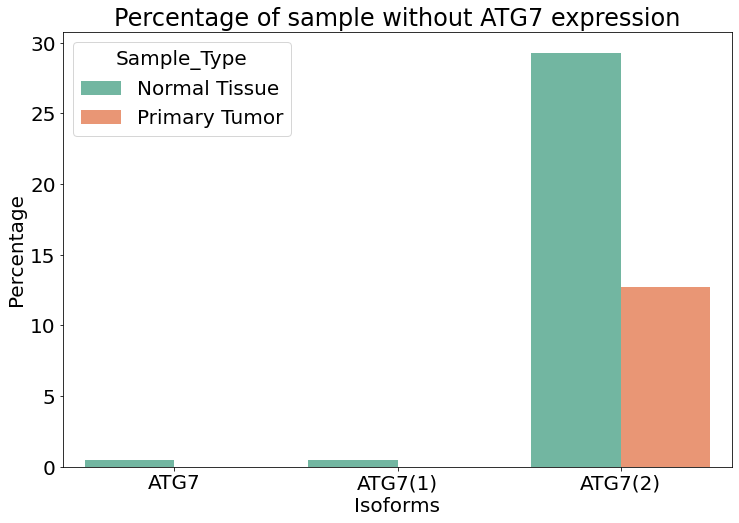

In [93]:
seaborn.barplot(data=df_noexpr_distrib, x="Isoforms", y="Percentage", hue="Sample_Type", 
                palette = 'Set2', orient = 'v')
plt.title("Percentage of sample without ATG7 expression")
plt.yticks(fontsize=20)


plt.savefig(output_file_directory+path+'percentage_expression.svg')

## C) Expression figures

### 1) Value TPM

16614


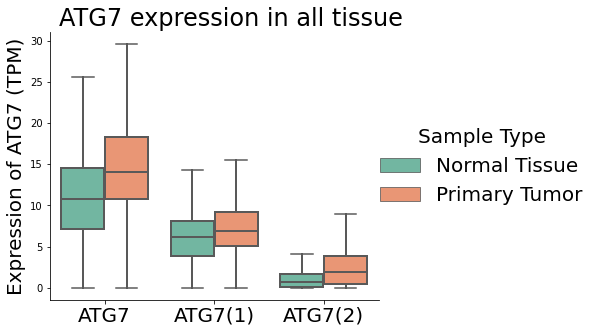

In [94]:
# Distribution: Data preparation + graph
Data = df_ATG7_NormPrim
info = 'all tissue'

shape = Data.shape
shape = shape[0]
print(shape)

#select the sample type column
sample_type = {'sample_type':[Data.iloc[:,1][i]
  for i in range(0, shape)]}

#convert to df, and copy it 3 times
sample_typedf = pandas.DataFrame(sample_type)
sample_typedf = pandas.concat([sample_typedf,sample_typedf,sample_typedf])
sample_typedf.reset_index(drop=True, inplace=True)

# Y for expression value 
y = {'y':[Data.iloc[:,j][i]
  for j in range(7,10)
    for i in range(0, shape)]}

#create df with Y 
data_distrib = pandas.DataFrame(y)

# X for ATG7/iso1/iso2                              
data_distrib.loc[:shape,'x'] = 'ATG7'
data_distrib.loc[shape: shape*2,'x'] = 'ATG7(1)'
data_distrib.loc[shape*2:,'x'] = 'ATG7(2)'

# Will be used for Hue
data_distrib['Sample Type'] = sample_typedf['sample_type']

#graph
seaborn.catplot(x="x", y="y", hue="Sample Type", aspect= 1.2, kind="box", palette = 'Set2', data = data_distrib, 
              boxprops={'lw':2}, medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)

plt.ylabel('Expression of ATG7 (TPM)')
plt.xlabel('')
plt.title('ATG7 expression in '+ info, x=.55)

#save

plt.savefig(output_file_directory+path+'ATG7_exp_alltissue.svg')

In [95]:
#Distribution: Stats for all 

all_dfs = [[df_ATG7_Normal, 'all normal tissue', df_ATG7_Primary, 'all primary tumors']]

isoforms = ['ATG7_total', 'ATG7_1tpm', 'ATG7_2tpm']

for df in all_dfs:
  for isoform in isoforms:

    n1 = "{:.3f}".format(numpy.median(df[0][isoform]))
    n2 = "{:.3f}".format(numpy.median(df[2][isoform]))

    # Mann-Whitney analysis 
    statistic, pvalue = scipy.stats.mannwhitneyu(df[0][isoform], df[2][isoform])
    Pvalue = "{:.3E}".format(pvalue)
    print("the pvalue between", df[1]+'('+n1+')', "and", df[3]+'('+n2+')', "for", isoform, 'is', Pvalue)
  print()


the pvalue between all normal tissue(10.460) and all primary tumors(14.073) for ATG7_total is 4.894E-252
the pvalue between all normal tissue(6.271) and all primary tumors(6.670) for ATG7_1tpm is 3.712E-33
the pvalue between all normal tissue(0.460) and all primary tumors(2.010) for ATG7_2tpm is 5.541E-295



In [96]:
#median brut file to compare 
print(df_ATG7_NormPrim['ATG7_total'].mean())
print(df_ATG7_NormPrim['ATG7_1tpm'].mean())
print(df_ATG7_NormPrim['ATG7_2tpm'].mean())

13.330134367799564
6.849488322969236
1.8954335752090787


In [97]:
#median after modification to be sure I selected the good ones
data_distribtest = data_distrib[data_distrib['x'] == 'ATG7']
data_distribtest1 = data_distrib[data_distrib['x'] == 'ATG7(1)']
data_distribtest2 = data_distrib[data_distrib['x'] == 'ATG7(2)']
print(data_distribtest.mean())
print(data_distribtest1.mean())
print(data_distribtest2.mean())

y    13.330134
dtype: float64
y    6.849488
dtype: float64
y    1.895434
dtype: float64


### 2) Normalized

16614


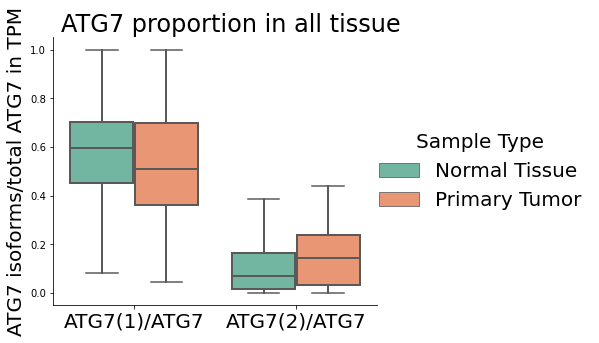

In [98]:
# NORMALiZED Distribution: Data preparation + graph
# Distribution: Data preparation + graph
Data = df_ATG7_NormPrim
info = 'all tissue'

shape = Data.shape
shape = shape[0]
print(shape)

#select the sample type column
sample_type = {'sample_type':[Data.iloc[:,1][i]
  for i in range(0, shape)]}

#convert to df, and copy it 3 times
sample_typedf = pandas.DataFrame(sample_type)
sample_typedf = pandas.concat([sample_typedf,sample_typedf,sample_typedf])
sample_typedf.reset_index(drop=True, inplace=True)

# Y for expression value 
y = {'y':[Data.iloc[:,j][i]
  for j in range(18,20)
    for i in range(0, shape)]}

#create df with Y 
data_distrib = pandas.DataFrame(y)

# X for ATG7/iso1/iso2                              
data_distrib.loc[:shape,'x'] = 'ATG7(1)/ATG7'
data_distrib.loc[shape:,'x'] = 'ATG7(2)/ATG7'

# Will be used for Hue
data_distrib['Sample Type'] = sample_typedf['sample_type']

#graph
seaborn.catplot(x="x", y="y", hue="Sample Type", aspect= 1.2, kind="box", palette = 'Set2', data = data_distrib, 
              boxprops={'lw':2}, medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)

plt.ylabel('ATG7 isoforms/total ATG7 in TPM')
plt.xlabel('')
plt.title('ATG7 proportion in '+ info, x=0.55)

#save graph
plt.savefig(output_file_directory+path+'prop_alltissue.svg')



In [99]:
#NORMALIZED Distribution: Stats for all 

all_dfs = [[df_ATG7_Normal, 'all normal tissue', df_ATG7_Primary, 'all primary tumors']]

isoforms = ['ATG7_1norm', 'ATG7_2norm']
print('NORMALIZED')

for df in all_dfs:
  for isoform in isoforms:

    n1 = "{:.3f}".format(numpy.median(df[0][isoform]))
    n2 = "{:.3f}".format(numpy.median(df[2][isoform]))

    # Mann-Whitney analysis 
    statistic, pvalue = scipy.stats.mannwhitneyu(df[0][isoform], df[2][isoform])
    Pvalue = "{:.3E}".format(pvalue)
    print("the pvalue between", df[1]+'('+n1+')', "and", df[3]+'('+n2+')', "for", isoform, 'is', Pvalue)
  print()


NORMALIZED
the pvalue between all normal tissue(0.630) and all primary tumors(0.495) for ATG7_1norm is 1.032E-145
the pvalue between all normal tissue(0.049) and all primary tumors(0.154) for ATG7_2norm is 9.956E-246



## D) Correlation between the two isoforms

In [100]:
#Remove the 0.5% extremities to have a nicer graph
tissues = [[df_ATG7_Normal, "Normal tissue"], [df_ATG7_Primary, "Primary tumor"]]
isoforms = ['ATG7_1', 'ATG7_2']
df_final = []

for tissue in tissues:
 
    #Remove 0.5% extremities
    df_no_extrem = []
    for isoform in isoforms:
        print(tissue[1], ':', tissue[0].shape)
        #sort by value, 
        for_isoforms = tissue[0].sort_values([isoform], ascending = False)
        print(isoform)
        
        #remove the extremities
        lenght = len(for_isoforms)
        without_05perc = int(lenght*0.005)
        print('', without_05perc, 'are removed from head and tail')
        without_head = without_05perc
        without_tail = lenght - without_05perc
                
        df_no_extremities = for_isoforms.iloc[without_head:without_tail,:]
        print(' without extremities:', df_no_extremities.shape)
        print()
        df_no_extrem.append(df_no_extremities)
        
    #drop the unfiltered column ATG7_2 ([0]) and replace it with the filtered one ([1]) 
    df_no_extrem[0].pop("ATG7_2")
    #add column ATG7_2 (filtered one) at the correct position
    df_no_extrem[0].insert(5, "ATG7_2", df_no_extrem[1]['ATG7_2'])
    #remove NaN (the deleted samples for the two isoform)
    df = df_no_extrem[0].dropna(axis=0)
    df_final.append(df)
    print('df_final after merge of the two filtered columns:', df.shape)
    print('________________________')
    #now, need to compute the two isoform with sample name.

Normal tissue : (4453, 20)
ATG7_1
 22 are removed from head and tail
 without extremities: (4409, 20)

Normal tissue : (4453, 20)
ATG7_2
 22 are removed from head and tail
 without extremities: (4409, 20)

df_final after merge of the two filtered columns: (4365, 20)
________________________
Primary tumor : (6881, 20)
ATG7_1
 34 are removed from head and tail
 without extremities: (6813, 20)

Primary tumor : (6881, 20)
ATG7_2
 34 are removed from head and tail
 without extremities: (6813, 20)

df_final after merge of the two filtered columns: (6746, 20)
________________________


The correlation between iso1 and iso2 in Normal tissue is: 0.15512544706419704 6.458574496152229e-25


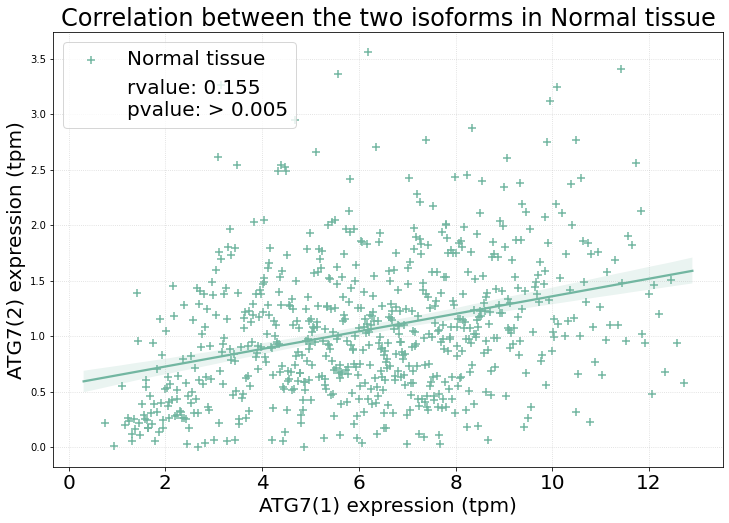


The correlation between iso1 and iso2 in Primary tumor is: -0.1866884675629981 5.81270691569753e-54


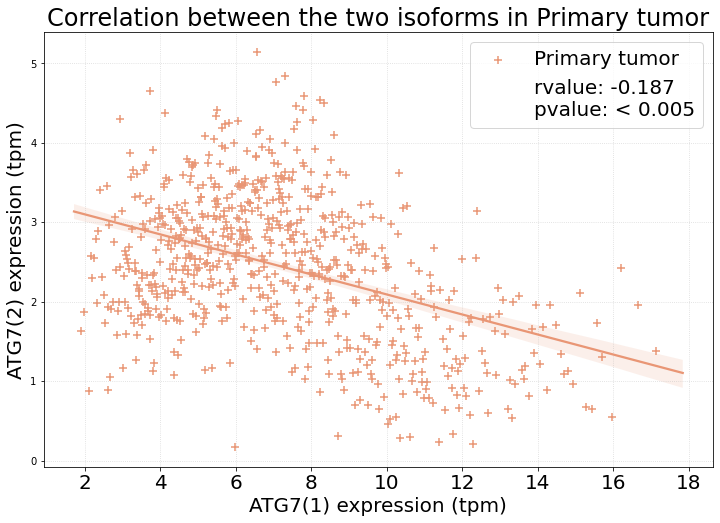

<Figure size 864x576 with 0 Axes>

In [101]:
#Graph and stats_ spearman correlation
#graph
df_final
color1 = '#72B6A1'
color2 = '#e99675'

normal_tissues = [df_final[0], "Normal tissue", '> 0.005', color1]
primary_tissues = [df_final[1], "Primary tumor", "< 0.005", color2]
tissues_no_extrem = normal_tissues, primary_tissues

for tissue in tissues_no_extrem:
    x = tissue[0]['ATG7_1tpm'].to_list()
    y = tissue[0]['ATG7_2tpm'].to_list()    
    
    #stat Spearman correlation 
    r_value, p_value = scipy.stats.spearmanr(x, y)
    print("The correlation between iso1 and iso2 in",tissue[1],"is:", r_value, p_value)
    
    #graph
    seaborn.regplot(x=x,y=y, x_bins=800, x_ci = 0, marker="+", label = tissue[1], color = tissue[3])
    seaborn.regplot(x=[],y=[], marker=" ", label= 'rvalue: '+str(round(r_value,3))+ "\npvalue: "+str(tissue[2]))

    name = "Correlation between the two isoforms in " + tissue[1]
    plt.title(name)
    plt.xlabel("ATG7(1) expression (tpm)")
    plt.ylabel('ATG7(2) expression (tpm)')

    plt.grid(ls = ":", alpha=0.5)
    plt.legend()

    #save
    path = 'ATG7/TCGA_GTEX/all_tissue/figs_ATG7_characterisation/'
    title_file = 'ATG7s_corr_tpm_' + tissue[1]
    plt.savefig(output_file_directory+path+title_file+'.svg')

    plt.show()  
    plt.clf()
    print()